In [1]:
# Challenge: https://www.kaggle.com/c/yelp-restaurant-photo-classification
import os
import numpy as np
import pandas as pd
import IPython
from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import misc
import pickle
import pydot

# Keras (https://github.com/fchollet/keras/)
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, Adam
from keras.regularizers import l2


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

Using Theano backend.


## Yelp data provider class

In [3]:
"""
-- Members --
train_photos_to_bizid_tbl: table photo - biz id
train_bizid_to_attrib_tbl: table biz id - attributes

train_biz_to_ps: dictionary biz id to photos
train_p_to_biz: dictionary photo to biz id
train_biz_to_attribs: dictionary biz id to attributes
"""
class YelpDataProvider(object):
    
    restaurant_attributes = {0: "good_for_lunch", 1: "good_for_dinner", 
                                2: "takes_reservations", 3: "outdoor_seating", 
                                4: "restaurant_is_expensive", 5: "has_alcohol", 
                                6: "has_table_service", 7: "ambience_is_classy", 
                                8: "good_for_kids"}
    
    # get business attributes in array of string
    def get_business_attribs(self, biz_id):
        
        return self.train_bizid_to_attrib_tbl[ \
                        self.train_bizid_to_attrib_tbl['business_id'] == biz_id]['labels'].tolist()[0].split(" ")
    
    def __init__(self, data_dir="../input", processed_data_dir="../pdata", test_data_dir="../test", save_processed = True):
        
        self.data_dir = data_dir
        self.processed_data_dir = processed_data_dir
        self.test_data_dir = test_data_dir
        self.train_photos_dir = os.path.join(data_dir,'train_photos')
        
        if save_processed and os.path.isdir(processed_data_dir):
            
            self.train_photos_to_bizid_tbl = pd.read_csv(
                        os.path.join(processed_data_dir, 'train_photo_to_biz_ids.csv'))
            self.train_bizid_to_attrib_tbl = pd.read_csv(
                        os.path.join(processed_data_dir, 'train.csv'))
            
            self.train_biz_to_ps = pickle.load( open( 
                        os.path.join(processed_data_dir, "train_biz_to_ps.pkl"), "rb"))
            self.train_p_to_biz = pickle.load( open(
                        os.path.join(processed_data_dir, "train_p_to_biz.pkl"), "rb"))
            self.train_biz_to_attribs = pickle.load( open( 
                        os.path.join(processed_data_dir, "train_biz_to_attribs.pkl"), "rb"))
            
        else:
            self.train_photos_to_bizid_tbl = pd.read_csv(os.path.join(data_dir,'train_photo_to_biz_ids.csv'))
            self.train_bizid_to_attrib_tbl = pd.read_csv(os.path.join(data_dir,'train.csv'))
            
            # remove nas and duplicates
            self.train_bizid_to_attrib_tbl = self.train_bizid_to_attrib_tbl.dropna()
            self.train_bizid_to_attrib_tbl = self.train_bizid_to_attrib_tbl.drop_duplicates()
            
            # remove entries with no matching entry in attributes table
            self.train_photos_to_bizid_tbl['has_attribs'] = \
                            self.train_photos_to_bizid_tbl['business_id'].apply(
                                lambda x: True if x in self.train_bizid_to_attrib_tbl.business_id.values else False)
            self.train_photos_to_bizid_tbl = self.train_photos_to_bizid_tbl[ \
                                                    self.train_photos_to_bizid_tbl['has_attribs'] == True]
            self.train_photos_to_bizid_tbl = self.train_photos_to_bizid_tbl.drop('has_attribs', axis=1)
            for attrib_key,attrib in self.restaurant_attributes.items():
                self.train_bizid_to_attrib_tbl[attrib] = \
                            self.train_bizid_to_attrib_tbl['labels'].str.contains(str(attrib_key))
            
            # Dictionary: BIZ ID (one) -> Photos (many)
            self.train_biz_to_ps = {
                    k: g["photo_id"].tolist() for k,g in self.train_photos_to_bizid_tbl.groupby("business_id")}
            # Dictionary:  Photo (one) -> BIZ ID (one)
            self.train_p_to_biz = {
                    k: g["business_id"].values[0] for k,g in self.train_photos_to_bizid_tbl.groupby("photo_id")}
        
            self.train_biz_to_attribs = {
                    biz_id: self.get_business_attribs(biz_id) for biz_id in self.train_bizid_to_attrib_tbl['business_id']}
        
            if save_processed:
                # create dir to store processed data
                os.mkdir(os.path.join(processed_data_dir))

                # save processed tables to disk
                self.train_photos_to_bizid_tbl.to_csv( 
                        os.path.join(processed_data_dir, 'train_photo_to_biz_ids.csv'), index=False)
                self.train_bizid_to_attrib_tbl.to_csv(
                        os.path.join(processed_data_dir, 'train.csv'), index=False)

                # save dicts to disk
                pickle.dump(self.train_biz_to_ps, open( 
                            os.path.join(processed_data_dir, "train_biz_to_ps.pkl"), "wb"))
                pickle.dump(self.train_p_to_biz, open( 
                            os.path.join(processed_data_dir,"train_p_to_biz.pkl"), "wb"))
                pickle.dump(self.train_biz_to_attribs, open( 
                            os.path.join(processed_data_dir,"train_biz_to_attribs.pkl"), "wb"))
        
        self.total_num_train = len(self.train_p_to_biz)
        self.total_num_biz = len(self.train_biz_to_ps)

    # output labels
    def get_business_attribs_one_hot_enc(self, biz_id, num_classes=len(restaurant_attributes)):
        return np.array([ (0,1)[str(i) in self.get_business_attribs(biz_id)] for i in range(num_classes)])
    
    # read training image by index
    def read_train_image_at_idx(self, img_idx):
        return self.read_train_image(list(self.train_p_to_biz.keys())[img_idx])
    
    # read training image by image id
    def read_train_image(self, img_id):
        return misc.imread(os.path.join(self.train_photos_dir, str(img_id)+".jpg"))
    
    # preprocess image
    def __prepare_image_vggnet(self, img, resize_dim=(224, 224, 3), 
                                   sub_vgg_mean=False, depth_first=True, dtype=np.float32):
        
        img = misc.imresize(img, resize_dim, interp="nearest").astype(dtype)
        
        if sub_vgg_mean:
            img[:,:,0] -= 103.939
            img[:,:,1] -= 116.779
            img[:,:,2] -= 123.68

        if depth_first:
            img = img.transpose((2,0,1))
            
        return img

    # sample images from training dataset
    def sample_training_minibatch(self, size = 16, resize_input_to = (224, 224, 3), 
                                    num_classes = 9, percent_validation = 0, 
                                    preprocess = True, depth_first = True, 
                                    dtype=np.float32):
        
        width, height, channels = resize_input_to
        
        # Get whole dataset
        if size == -1:
            size = self.total_num_train
        
        # Train <-> Valid split
        num_train = int(size * (1.0 - percent_validation))
        num_valid = size - num_train
        
        # Random sample the dataset
        rand_idxs = np.random.randint(0, self.total_num_train, size)
        X_train = np.array([self.__prepare_image_vggnet(self.read_train_image_at_idx(rand_id), 
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                            for rand_id in rand_idxs[:num_train]])
        y_train = np.array([self.get_business_attribs_one_hot_enc(list(self.train_p_to_biz.values())[rand_id], 
                                                                num_classes) for rand_id in rand_idxs[:num_train]])
        if not num_valid:
            return X_train, y_train
        
        X_valid = np.array([self.__prepare_image_vggnet(self.read_train_image_at_idx(rand_id), 
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                                        for rand_id in rand_idxs[-num_valid:]])
        y_valid = np.array([self.get_business_attribs_one_hot_enc(list(self.train_p_to_biz.values())[rand_id], 
                                                                num_classes) for rand_id in rand_idxs[-num_valid:]])
        
        return X_train, y_train, X_valid, y_valid
    
    def sample_training_minibatch_by_class(self, class_name, max_biz = 10, max_biz_imgs = 10,
                                                resize_input_to = (224, 224, 3), 
                                                num_classes = 9, percent_validation = 0, 
                                                preprocess = True, depth_first = True, 
                                                dtype=np.float32):
    
        # iterate over business with attrib class_name
        filtered_tbl = self.train_bizid_to_attrib_tbl[self.train_bizid_to_attrib_tbl[class_name] == True]
   
        for biz_idx, biz_id in enumerate(filtered_tbl["business_id"].values[:max_biz]):
            # iterate over all photos of that particular business 
            for img_id in self.train_biz_to_ps[biz_id][:max_biz_imgs]:
                yield self.__prepare_image_vggnet(self.read_train_image(img_id),
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype)

## Read input data

In [4]:
yelp_data_provider = YelpDataProvider(save_processed=True)

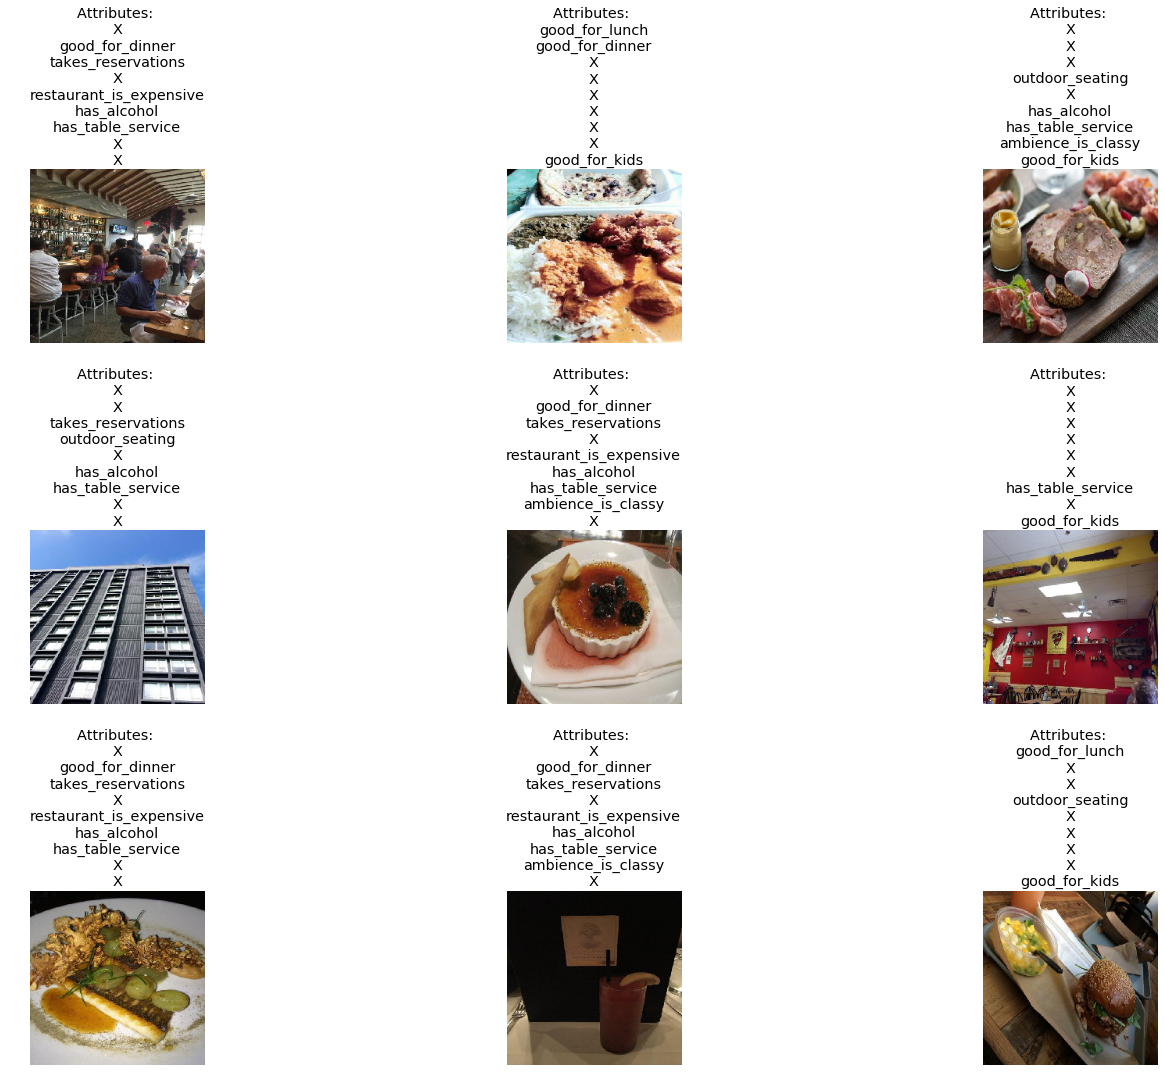

In [6]:
# sample few images
num_samples = 9
X_train, y_train = yelp_data_provider.sample_training_minibatch(size=num_samples, preprocess = False, 
                                                                    depth_first = False, dtype=np.uint8)
for i in range(num_samples):
    plt.subplot(np.sqrt(num_samples)+1, np.sqrt(num_samples), i+1)
    plt.axis('off')
    plt.title("Attributes: \n" + 
              "\n".join([ ("X", yelp_data_provider.restaurant_attributes[idx])[val] \
                                     for idx,val in enumerate(y_train[i])]), fontsize="x-large")
    plt.imshow(X_train[i])
plt.tight_layout()

## Visualize class images

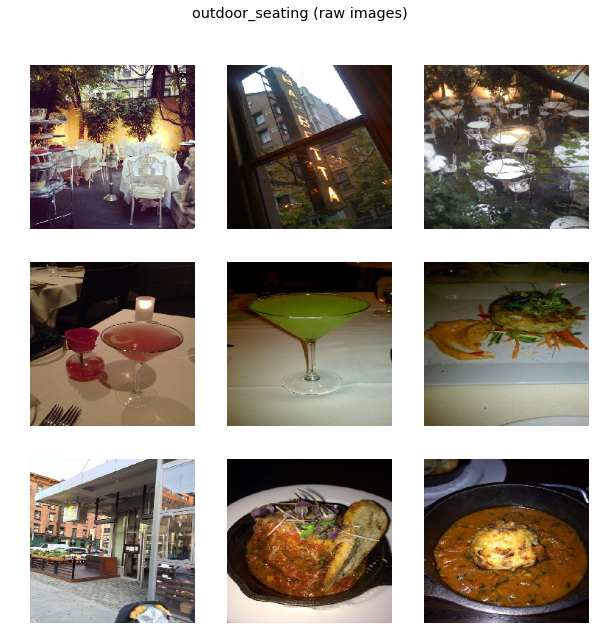

In [8]:
class_name =  "outdoor_seating"
fig = plt.figure(1, figsize=(10,10))
st = fig.suptitle(class_name + " (raw images)", fontsize="x-large")
max_biz, max_imgs_per_biz = 3, 3
for image_no, img in enumerate(yelp_data_provider.sample_training_minibatch_by_class(class_name, max_biz, max_imgs_per_biz, 
                                                                    preprocess = False, depth_first = False, 
                                                                    dtype=np.uint8)):
    plt.subplot(max_biz, max_imgs_per_biz, image_no+1)
    plt.axis("off")
    plt.imshow(img)

## Tansfer learning from ImageNet VGG16

In [43]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [44]:
vgg16_model = VGG_16('vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy')

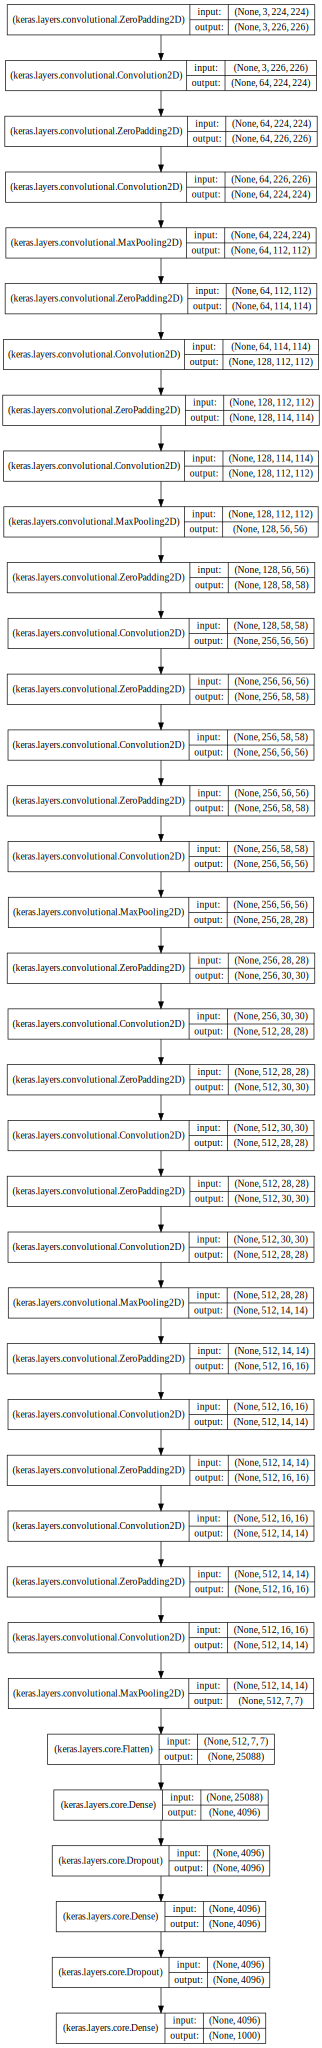

In [46]:
# To display model arch
SVG(to_graph(vgg16_model, show_shape=True).create(prog='dot', format='svg'))

In [10]:
def VGG_16_multilabel_gpu(weights_path=None):
    
    fc1_dim, fc2_dim, output_dim = 1024, 512, 1
    l2_reg = 0.01
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=(3,224,224))
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h2out", input="h2fc2_drop")
    
    m.add_output(name='output1', input='h1out')
    m.add_output(name='output2', input='h2out')

    if weights_path:
        print "loading pre-trained weights from ", weights_path
        m.load_weights(weights_path)

    return m

In [11]:
yelp_model = VGG_16_multilabel_gpu("./vgg16_multilabel_gpu_weights.h5") 
# yelp_model = VGG_16_multilabel_gpu() 

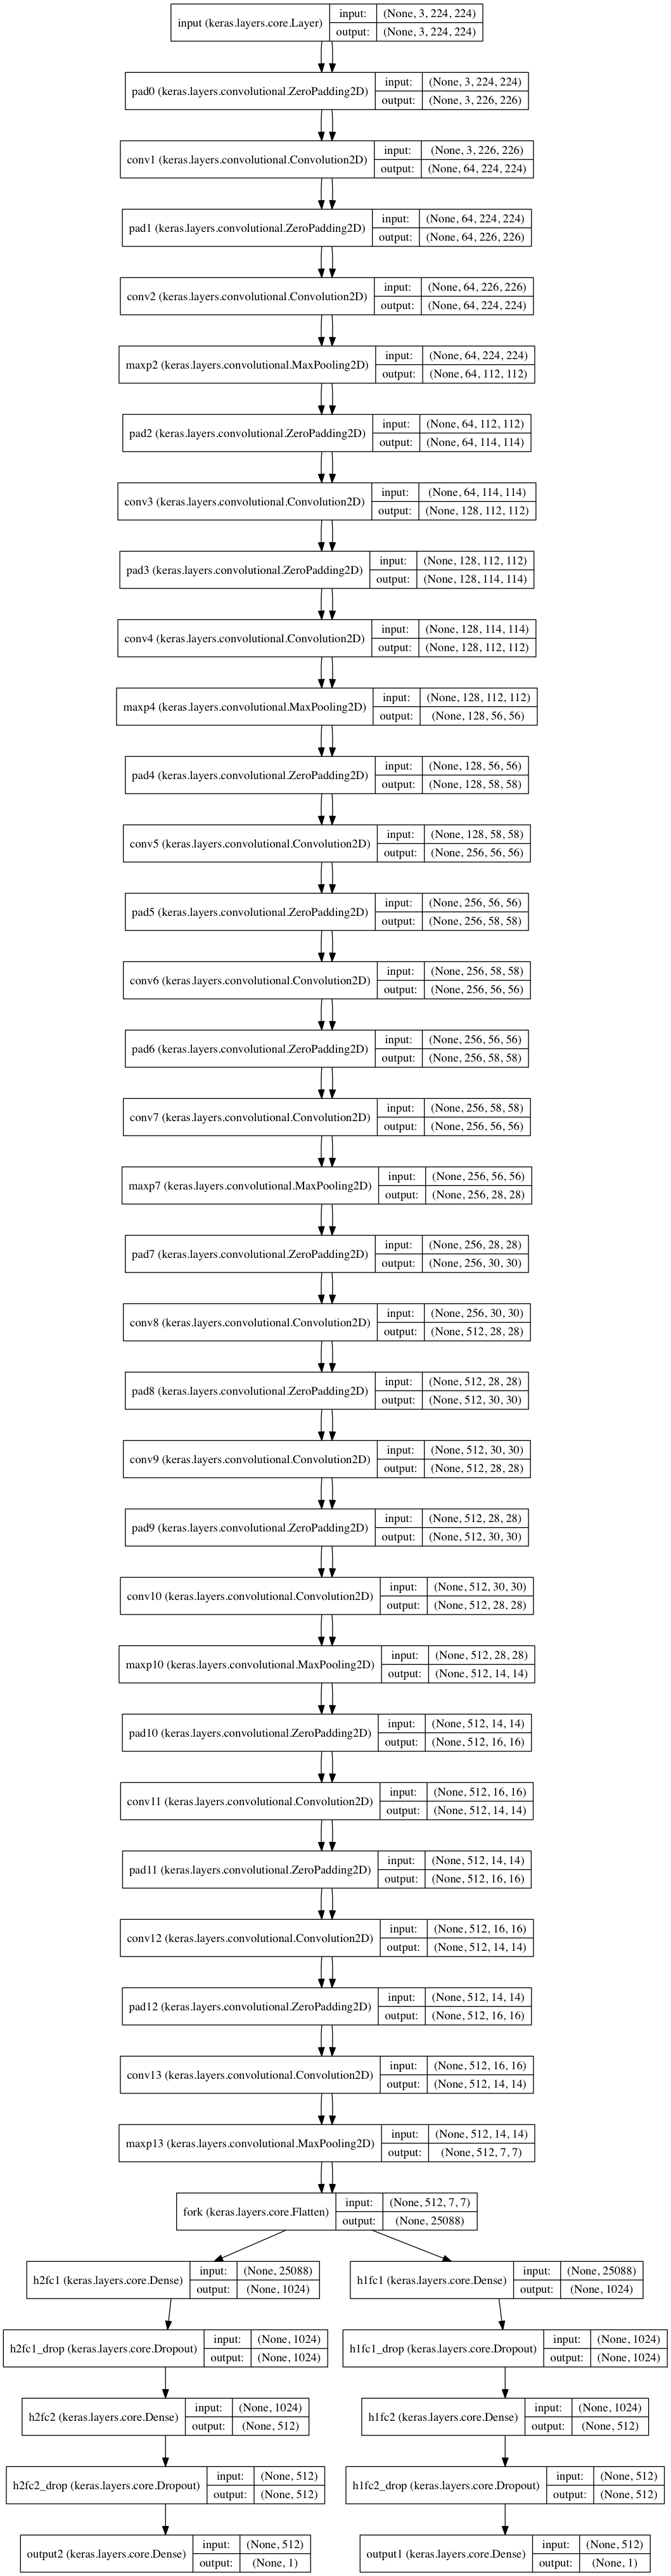

In [53]:
# display graph
plot(yelp_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png')

## Weight initialization

In [134]:
# transfer learning
conv_idx = 0
for i in range(32):
    #if "conv" in vgg16_model.layers[i].name: # works on latest keras
    if "Convolution2D" in str(vgg16_model.layers[i]):
        conv_idx += 1
        conv_layer_name = "conv" + str(conv_idx)
        if conv_layer_name in yelp_model.namespace:
            print "Transfer vgg layer", i, "to yelp model conv", conv_idx
            yelp_model.nodes[conv_layer_name].W.set_value(vgg16_model.layers[i].get_weights()[0]);
            yelp_model.nodes[conv_layer_name].b.set_value(vgg16_model.layers[i].get_weights()[1]);

Transfer vgg layer 1 to yelp model conv 1
Transfer vgg layer 3 to yelp model conv 2
Transfer vgg layer 6 to yelp model conv 3
Transfer vgg layer 8 to yelp model conv 4
Transfer vgg layer 11 to yelp model conv 5
Transfer vgg layer 13 to yelp model conv 6
Transfer vgg layer 15 to yelp model conv 7
Transfer vgg layer 18 to yelp model conv 8
Transfer vgg layer 20 to yelp model conv 9
Transfer vgg layer 22 to yelp model conv 10
Transfer vgg layer 25 to yelp model conv 11
Transfer vgg layer 27 to yelp model conv 12
Transfer vgg layer 29 to yelp model conv 13


In [80]:
# freeze bottom layers
for node_name in yelp_model.nodes.keys():
    yelp_model.nodes[node_name].trainable = False
    if node_name == "conv4":
        break

## Create training data

In [16]:
print('Total images: {}'.format(yelp_data_provider.total_num_train))
X_train, y_train, X_valid, y_valid = yelp_data_provider.sample_training_minibatch(size=256, percent_validation=0.25)
print("Training size: {}, Validation size: {}".format(len(X_train), len(X_valid)))

Total images: 234545
Training size: 192, Validation size: 64


## Optimization

In [12]:
# sgd = SGD(lr=0.0005, decay=0.0, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
yelp_model.compile(optimizer=adam, loss={'output1':'binary_crossentropy', 'output2':'binary_crossentropy'})

/Users/yrevar/virtualenvs/keras/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [13]:
# Classifier with attribs "good_for_lunch" and "good_for_dinner"
history = yelp_model.fit( 
            {'input':X_train_mini, 
             'output1': X_train[:,0].squeeze().astype('bool'), 
             'output2': y_train[:,1].squeeze().astype('bool')}, 
            batch_size=32, verbose=1, nb_epoch=10, validation_split=0.25)

Train on 12 samples, validate on 4 samples
Epoch 1/2
12/12 [==============================] - 51s - loss: 20.2158 - val_loss: 8.0590
Epoch 2/2
12/12 [==============================] - 50s - loss: 13.0474 - val_loss: 8.0590


In [14]:
predictions = yelp_model.predict({'input': X_valid}, batch_size=32)

In [15]:
np.mean(y_valid[:,0] == np.array([1 if x >= 0.5 else 0 for x in predictions['output1']]))
np.mean(y_valid[:,1] == np.array([1 if x >= 0.5 else 0 for x in predictions['output2']]))

0.58333333333333337

In [ ]:
yelp_model.save_weights("./vgg16_multilabel_gpu_weights.h5")

## GPU Test

In [2]:
#GPU test
from theano import function, config, shared, tensor, sandbox
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


In [ ]:
# Check GPU Memory 
import theano.sandbox.cuda.basic_ops as sbcuda
import theano.tensor as T
T.config.floatX = 'float32'
GPUFreeMemoryInBytes = sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]
freeGPUMemInGBs = GPUFreeMemoryInBytes/1024./1024/1024
print "Your GPU has %s GBs of free memory" % str(freeGPUMemInGBs)